In [173]:
import requests
import json

In [174]:
#step 1
response = requests.get("https://dsl.richmond.edu/panorama/redlining/static/downloads/geojson/MIDetroit1939.geojson")
json_str = response.text
json_dict = json.loads(json_str)
RedliningData = json_dict['features'] #a list

In [175]:
#step 2
class DetroitDistrict:
    color = {'A': 'darkgreen', 'B': 'cornflowerblue', 'C': 'gold', 'D': 'maroon'}
    def __init__(self, district, name):
        self.Coordinates = district['geometry']['coordinates'][0][0]
        self.HolcGrade = district['properties']['holc_grade']
        self.HolcColor = DetroitDistrict.color[self.HolcGrade]
        self.name = name #index
        self.Qualitative_Description = district['properties']['area_description_data']['8']
        self.RandomLat = None
        self.RandomLong = None
        self.Median_Income = None
        self.CensusTract = None

In [176]:
Districts = [DetroitDistrict(RedliningData[i], i) for i in range(len(RedliningData))]

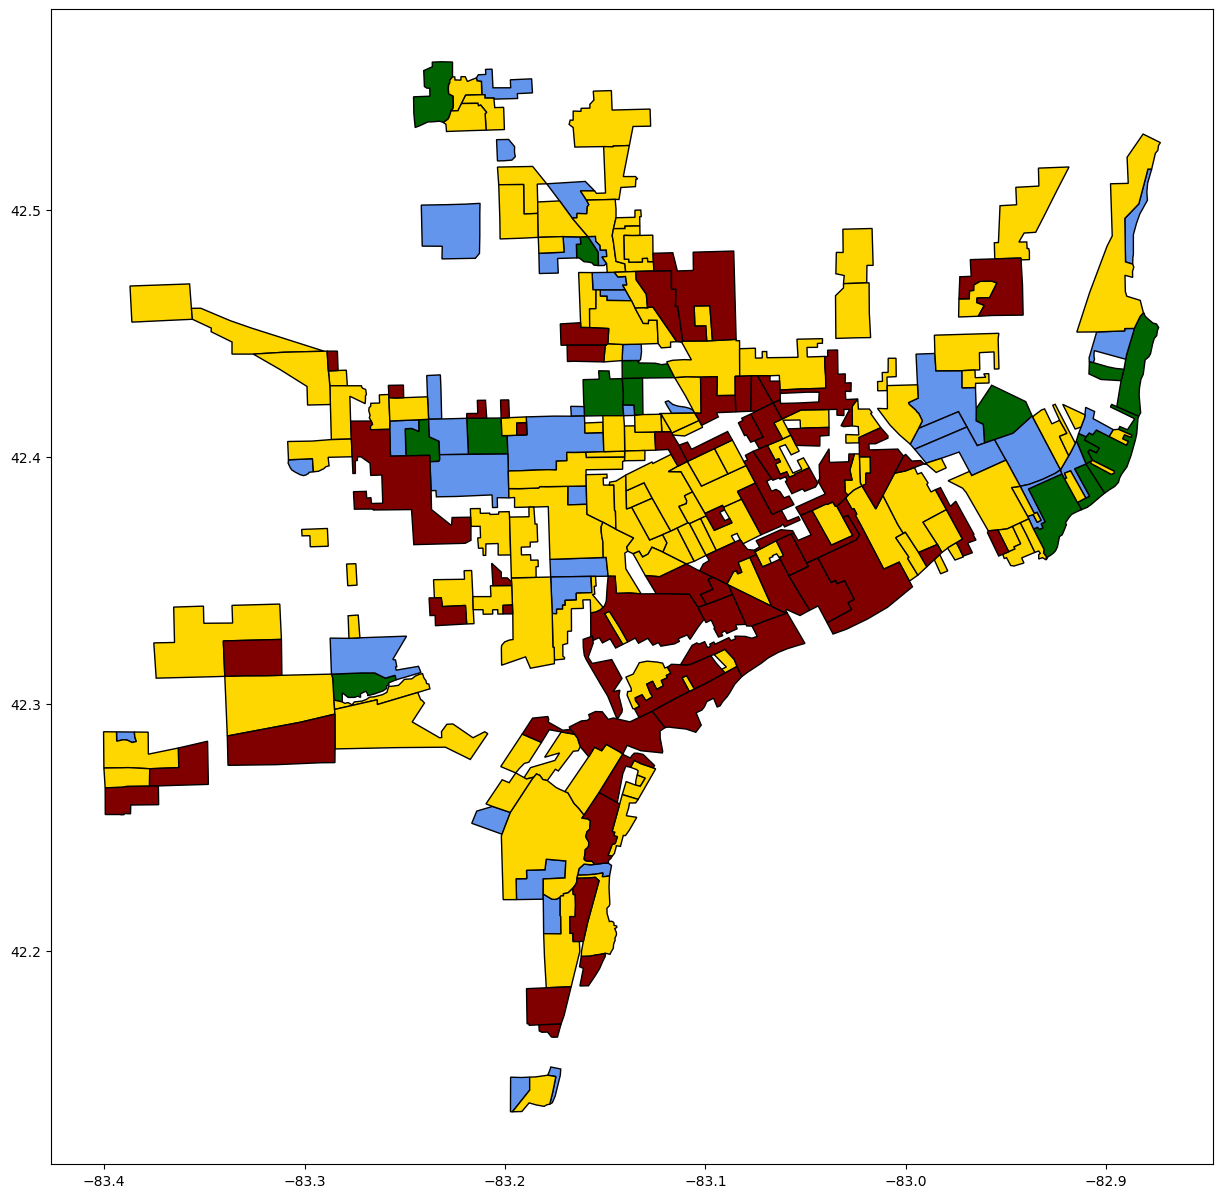

In [177]:
#step 3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
fig, ax = plt.subplots()
for district in Districts: # what kind of for loop makes sense?
    ax.add_patch(plt.Polygon(district.Coordinates, facecolor=district.HolcColor, edgecolor = 'black')) # add arguments here
    ax.autoscale()
    plt.rcParams["figure.figsize"] = (15,15)
plt.show()

In [31]:
# Choose a random point within the district
import random as random
from matplotlib.path import Path
import numpy as np
random.seed(17)

xgrid = np.arange(-83.5, -82.8, .004)
ygrid = np.arange(42.1, 42.6, .004)
xmesh, ymesh = np.meshgrid(xgrid, ygrid) #combine xgrid and y grid into an array of two elements

points = np.vstack((xmesh.flatten(), ymesh.flatten())).T #transpose the array into an array of points

for j in Districts:
    p = Path(j.Coordinates)
    grid = p.contains_points(points) #return an array of boolean values
    print(j, " : ", points[random.choice(np.where(grid)[0])]) #the first one in coordinates that contains points
    point = points[random.choice(np.where(grid)[0])]
    j.RandomLong = point[0]
    j.RandomLat = point[1]

<__main__.DetroitDistrict object at 0x000001C05C7862E0>  :  [-83.124  42.436]
<__main__.DetroitDistrict object at 0x000001C05C786490>  :  [-82.912  42.392]
<__main__.DetroitDistrict object at 0x000001C05C7862B0>  :  [-82.912  42.404]
<__main__.DetroitDistrict object at 0x000001C05C774DF0>  :  [-82.888  42.408]
<__main__.DetroitDistrict object at 0x000001C05C774E50>  :  [-82.892  42.424]
<__main__.DetroitDistrict object at 0x000001C05C774E20>  :  [-82.896  42.432]
<__main__.DetroitDistrict object at 0x000001C05C774E80>  :  [-83.276  42.312]
<__main__.DetroitDistrict object at 0x000001C05C774D90>  :  [-83.148  42.432]
<__main__.DetroitDistrict object at 0x000001C05C774D60>  :  [-83.132  42.428]
<__main__.DetroitDistrict object at 0x000001C05C774F40>  :  [-83.24   42.412]
<__main__.DetroitDistrict object at 0x000001C05B1F97C0>  :  [-83.208  42.404]
<__main__.DetroitDistrict object at 0x000001C05B1F9760>  :  [-82.944  42.424]
<__main__.DetroitDistrict object at 0x000001C05B1F9820>  :  [-83

<__main__.DetroitDistrict object at 0x000001C05C9DA9D0>  :  [-83.064  42.376]
<__main__.DetroitDistrict object at 0x000001C05C9DAA00>  :  [-83.072  42.392]
<__main__.DetroitDistrict object at 0x000001C05C9DAA30>  :  [-83.052  42.388]
<__main__.DetroitDistrict object at 0x000001C05C9DAA60>  :  [-83.036  42.388]
<__main__.DetroitDistrict object at 0x000001C05C9DAA90>  :  [-83.016  42.4  ]
<__main__.DetroitDistrict object at 0x000001C05C9DAAC0>  :  [-83.   42.4]
<__main__.DetroitDistrict object at 0x000001C05C9DAAF0>  :  [-83.108  42.352]
<__main__.DetroitDistrict object at 0x000001C05C9DAB50>  :  [-83.092  42.356]
<__main__.DetroitDistrict object at 0x000001C05C9DA850>  :  [-83.256  42.428]
<__main__.DetroitDistrict object at 0x000001C05C9DAB20>  :  [-83.06   42.368]
<__main__.DetroitDistrict object at 0x000001C05C9DAB80>  :  [-83.052  42.356]
<__main__.DetroitDistrict object at 0x000001C05C9DABB0>  :  [-83.048  42.36 ]
<__main__.DetroitDistrict object at 0x000001C05C9DABE0>  :  [-83.136

In [34]:
for district in Districts:
    lat = str(district.RandomLat)
    lon = str(district.RandomLong)
    census = requests.get("https://geo.fcc.gov/api/census/area?lat=" + lat + "&lon=" + lon + "&censusYear=2010&format=json")
    census_str = census.text
    census_dict = json.loads(census_str)
    census_tract = census_dict['results'][0]['block_fips'][5:11]
    district.CensusTract = census_tract

In [55]:
income = requests.get("https://api.census.gov/data/2018/acs/acs5?get=B19013_001E&for=tract:*&in=state:26&key=44011c132f4e6c44649f0c0f92114f7ae5ba1393")
income_str = income.text
income_dict = json.loads(income_str)
for district in Districts:
    census = district.CensusTract
    for lst in income_dict[1:]:
        if census == lst[3]: 
            district.Median_Income = lst[0]
            break

In [178]:
#step 7
CACHE_FILENAME = "cache.json"

def open_cache():
    ''' opens the cache file if it exists and loads the JSON into
    a dictionary, which it then returns.
    if the cache file doesn't exist, creates a new cache dictionary
    Parameters
    ----------
    None
    Returns
    -------
    The opened cache
    '''
    try:
        cache_file = open(CACHE_FILENAME, 'r')
        cache_contents = cache_file.read()
        cache_dict = json.loads(cache_contents)
        cache_file.close()
    except:
        cache_dict = {'random':{}, 'census':{}, 'income':{}}
    return cache_dict

def save_cache(cache_dict):
    ''' saves the current state of the cache to disk
    Parameters
    ----------
    cache_dict: dict
        The dictionary to save
    Returns
    -------
    None
    '''
    dumped_json_cache = json.dumps(cache_dict)
    fw = open(CACHE_FILENAME,"w")
    fw.write(dumped_json_cache)
    fw.close() 
    
FIB_CACHE = open_cache() ###

#step4
import random as random
from matplotlib.path import Path
import numpy as np
random.seed(17)

xgrid = np.arange(-83.5, -82.8, .004)
ygrid = np.arange(42.1, 42.6, .004)
xmesh, ymesh = np.meshgrid(xgrid, ygrid) #combine xgrid and y grid into an array of two elements

points = np.vstack((xmesh.flatten(), ymesh.flatten())).T #transpose the array into an array of points

for j in Districts:
    name = str(j.name)
    if name in FIB_CACHE['random']:
        point = FIB_CACHE['random'][name]
    else:
        p = Path(j.Coordinates)
        grid = p.contains_points(points) #return an array of boolean values
        print(j, " : ", points[random.choice(np.where(grid)[0])]) #the first one in coordinates that contains points
        point = list(points[random.choice(np.where(grid)[0])])
        FIB_CACHE['random'][name] = point
        save_cache(FIB_CACHE)
        point = FIB_CACHE['random'][name]
        
    j.RandomLong = point[0]
    j.RandomLat = point[1]
    
    
#step5
for district in Districts:
    name = str(district.name)
    if name in FIB_CACHE['census']:
        census_tract = FIB_CACHE['census'][name]
    else:
        lat = str(district.RandomLat)
        lon = str(district.RandomLong)
        census = requests.get("https://geo.fcc.gov/api/census/area?lat=" + lat + "&lon=" + lon + "&censusYear=2010&format=json")
        census_str = census.text
        census_dict = json.loads(census_str)
        census_tract = census_dict['results'][0]['block_fips'][5:11]
        FIB_CACHE['census'][name] = census_tract
        save_cache(FIB_CACHE)
        census_tract = FIB_CACHE['census'][name]
    district.CensusTract = census_tract
    
#step6
if FIB_CACHE['income'] != {}:
    for district in Districts:
        name = str(district.name)
        medium_income = FIB_CACHE['income'][name]
        district.Median_Income = medium_income
else:  
    income = requests.get("https://api.census.gov/data/2018/acs/acs5?get=B19013_001E&for=tract:*&in=state:26&key=44011c132f4e6c44649f0c0f92114f7ae5ba1393")
    income_str = income.text
    income_dict = json.loads(income_str)
    for district in Districts:
        census = district.CensusTract
        name = str(district.name)
        for lst in income_dict[1:]:
            if census == lst[3]: 
                medium_income = lst[0]
                FIB_CACHE['income'][name] = medium_income
                save_cache(FIB_CACHE)
                medium_income = FIB_CACHE['income'][name]
                district.Median_Income = medium_income
                break

In [179]:
#step 8
income_A = []
income_B = []
income_C = []
income_D = []
for district in Districts:
    grade = district.HolcGrade
    if grade == 'A': income_A.append(int(district.Median_Income))
    elif grade == 'B': income_B.append(int(district.Median_Income))
    elif grade == 'C': income_C.append(int(district.Median_Income))
    elif grade == 'D': income_D.append(int(district.Median_Income))
A_mean_income = np.mean(income_A)
A_median_income = np.median(income_A)
B_mean_income = np.mean(income_B)
B_median_income = np.median(income_B)
C_mean_income = np.mean(income_C)
C_median_income = np.median(income_C)
D_mean_income = np.mean(income_D)
D_median_income = np.median(income_D)
print('A_mean_income: ', A_mean_income)
print('A_median_income: ', A_median_income)
print('B_mean_income: ', B_mean_income)
print('B_median_income: ', B_median_income)
print('C_mean_income: ', C_mean_income)
print('C_median_income: ', C_median_income)
print('D_mean_income: ', D_mean_income)
print('D_median_income: ', D_median_income)

A_mean_income:  97524.06666666667
A_median_income:  110870.0
B_mean_income:  67430.20512820513
B_median_income:  72782.0
C_mean_income:  42959.262295081964
C_median_income:  33446.0
D_mean_income:  31297.225806451614
D_median_income:  27437.5


In [180]:
#step 9
stopwords = {'&',
 "'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 '*See',
 '-',
 'A',
 'All',
 'Area',
 'Descriptions.',
 'On',
 'The',
 'There',
 'This',
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'area',
 'area.',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'explanation',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'front',
 'full',
 'further',
 'get',
 'give',
 'go',
 'grade.',
 'had',
 'has',
 'have',
 'he',
 'hence',
 'her',
 'here',
 'hereafter',
 'hereby',
 'herein',
 'hereupon',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'houses',
 'how',
 'however',
 'hundred',
 'i',
 'if',
 'in',
 'indeed',
 'into',
 'is',
 'it',
 'its',
 'itself',
 'just',
 'keep',
 'last',
 'latter',
 'latterly',
 'least',
 'less',
 'made',
 'make',
 'many',
 'may',
 'me',
 'meanwhile',
 'might',
 'mine',
 'more',
 'moreover',
 'most',
 'mostly',
 'move',
 'much',
 'must',
 'my',
 'myself',
 "n't",
 'name',
 'namely',
 'neighborhood',
 'neither',
 'never',
 'nevertheless',
 'next',
 'nine',
 'no',
 'nobody',
 'none',
 'noone',
 'nor',
 'not',
 'nothing',
 'now',
 'nowhere',
 'n‘t',
 'n’t',
 'of',
 'off',
 'often',
 'on',
 'once',
 'one',
 'only',
 'onto',
 'or',
 'other',
 'others',
 'otherwise',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'part',
 'per',
 'perhaps',
 'please',
 'put',
 'quite',
 'rather',
 're',
 'really',
 'regarding',
 'same',
 'say',
 'section',
 'see',
 'seem',
 'seemed',
 'seeming',
 'seems',
 'serious',
 'several',
 'she',
 'sheet',
 'should',
 'show',
 'side',
 'since',
 'six',
 'sixty',
 'so',
 'some',
 'somehow',
 'someone',
 'something',
 'sometime',
 'sometimes',
 'somewhere',
 'still',
 'such',
 'take',
 'ten',
 'than',
 'that',
 'the',
 'their',
 'them',
 'themselves',
 'then',
 'thence',
 'there',
 'thereafter',
 'thereby',
 'therefore',
 'therein',
 'thereupon',
 'these',
 'they',
 'third',
 'this',
 'those',
 'though',
 'three',
 'through',
 'throughout',
 'thru',
 'thus',
 'to',
 'together',
 'too',
 'top',
 'toward',
 'towards',
 'twelve',
 'twenty',
 'two',
 'under',
 'unless',
 'until',
 'up',
 'upon',
 'us',
 'used',
 'using',
 'various',
 'very',
 'via',
 'was',
 'we',
 'well',
 'were',
 'what',
 'whatever',
 'when',
 'whence',
 'whenever',
 'where',
 'whereafter',
 'whereas',
 'whereby',
 'wherein',
 'whereupon',
 'wherever',
 'whether',
 'which',
 'while',
 'whither',
 'who',
 'whoever',
 'whole',
 'whom',
 'whose',
 'why',
 'will',
 'with',
 'within',
 'without',
 'would',
 'yet',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 '‘d',
 '‘ll',
 '‘m',
 '‘re',
 '‘s',
 '‘ve',
 '’d',
 '’ll',
 '’m',
 '’re',
 '’s',
 '’ve'}

In [181]:
string_A = []
string_B = []
string_C = []
string_D = []
for district in Districts:
    grade = district.HolcGrade
    word_list = [word for word in district.Qualitative_Description.split() if not word in stopwords]
    if grade == 'A': string_A += word_list
    elif grade == 'B': string_B += word_list
    elif grade == 'C': string_C += word_list
    elif grade == 'D': string_D += word_list

from collections import Counter
collection_A = Counter(string_A)
collection_B = Counter(string_B)
collection_C = Counter(string_C)
collection_D = Counter(string_D)
A_10_Most_Common = [word for word, cnt in collection_A.most_common(10)]
B_10_Most_Common = [word for word, cnt in collection_B.most_common(10)]
C_10_Most_Common = [word for word, cnt in collection_C.most_common(10)]
D_10_Most_Common = [word for word, cnt in collection_D.most_common(10)]
print(A_10_Most_Common)
print(B_10_Most_Common)
print(C_10_Most_Common)
print(D_10_Most_Common)

['high', 'good', 'valued', 'class', 'developed.', 'city', 'estates', 'residential', 'Detroit', 'properties']
['good', 'developed.', 'new', 'fairly', 'east', 'better', 'shopping', 'singles', '"A"', 'substantial']
['3rd', 'singles', 'developed.', 'shopping', '2-flats', 'type', 'city', 'brick', 'construction', 'rates']
['4th', '2-flats', 'Ford', 'singles', 'type', 'above.', 'Many', 'priced', 'population', 'Otherwise']


## Bonus 2
Did the results in Step 6 or 7 surprise you?       
No. The median income in step 6 is reasonable which is higher on A districts and lower on D districs. The running time of step 7 is much faster when running the program the second time because it doesn't have to get API from the website, only from the local cache file.     
Have these 2 HW assignments changed your prior understanding of segregation in any way?    
Yes. I didn't expect such a high difference of income of different neighborhoods even until now that the D's median income is only 1/4 of that of A.    
What systemic effects would you want to simulate with the python skills you have now?     
I want to simulate whether the rate of change of umemployment rate is related to the segragation of neighborhoods.

In [187]:
new = ''
palindromeStr = 'aaa'
for i in range(len(palindromeStr)):
        if palindromeStr[i] == 'a': 
            new += palindromeStr[i]
            continue
        else:
            new += 'a'
            break
if i == len(palindromeStr): print('IMPOSSIBLE')
else:
    new += palindromeStr[i+1:]
    print(new)
print(i)

aaa
2


In [188]:
'a' * len('aaaa')

'aaaa'

In [194]:
a = [5, 2, 3, 4]
b = [3,4,3,4]
#a: money, b: bundle quantity
per = [x/y for x, y in zip(a, b)]
per.sort()
per

[0.5, 1.0, 1.0, 1.6666666666666667]

In [196]:
import pandas as pd
d = {'quantity': a, 'cost': b, 'per_price': per}
df = pd.DataFrame(data=d)
df = df.sort_values(by = 'per_price') #min to max

In [197]:
df

,quantity,cost,per_price
0,5,3,0.500000
1,2,4,1.000000
2,3,3,1.000000
3,4,4,1.666667


In [206]:
i = 0
book = 0
n = 50
while n > 0:
    book += (n//df['cost'][i]) * df['quantity'][i]
    n = n%df['cost'][i]
    i += 1
    if n//df['cost'][i] < 1: break
print(book)
    

80


In [198]:
50%20

10

In [199]:
50//20

2

In [203]:
df['quantity'][1]

2

In [204]:
10//11

0

In [ ]:

public class BudgetShopping {
    static int budgetShopping(int n, int[] bundleQuantities, int[] bundleCosts) {
        return exploreCombinations(n, 0, 0, bundleQuantities, bundleCosts);
    }

    static int exploreCombinations(int budget, int currentQuantity, int currentCost, int[] bundleQuantities, int[] bundleCosts) {
        int maxQuantity = currentQuantity;
        for (int i = 0; i < bundleQuantities.length; i++) {
            if (currentCost + bundleCosts[i] <= budget) {
                int amount = exploreCombinations(budget, currentQuantity + bundleQuantities[i], currentCost + bundleCosts[i], bundleQuantities, bundleCosts);
                if (maxQuantity < amount) {
                    maxQuantity = amount;
                }
            }
        }
        return maxQuantity;
    }

    public static void main(String[] args) {

        int[] quantities = {20, 19};
        int[] costs = {24, 20};

        int i = budgetShopping(50, quantities, costs);
        System.out.println("Max shopping "+i);
    }
}

In [ ]:
return combination(n, 0, 0, bundleQuantities, bundleCosts)

def combination(n, current_book, current_cost, bundleQuantities, bundleCosts):
    max_book = current_book
    for i in range(len(bundleQuantities)):
        if current_cost + bundleCosts[i] <= n:
            book_number = combination(n, current_book + bundleQuantities[i], current_cost + bundleCosts[i], bundleQuantities, bundleCosts)
            if book_number > max_book: max_book = book_number
    return max_book

In [ ]:
print(n)
    print(bundleQuantities)
    print(bundleCosts)
    import pandas as pd
    per = [x/y for x, y in zip(bundleCosts, bundleQuantities)]
    d = {'quantity': bundleQuantities, 'cost': bundleCosts, 'per_price': per}
    df = pd.DataFrame(data=d)
    df = df.sort_values(by = 'per_price') #min to max
    
    ##tested on my own IDE
    i = 0
    book = 0
    while n > 0:
        book += (n//df['cost'][i]) * df['quantity'][i]
        n = n%df['cost'][i]
        i += 1
        if n//df['cost'][i] < 1: break
    return book

In [208]:
dic = {}
dic[(1,2,3)] = 1

In [209]:
dic

{(1, 2, 3): 1}

In [ ]:
def combination(n, _cache={}):
    if n in _cache:
        return _cache[n]
    elif n > 1:
        return _cache.setdefault(n, cache_fib(n-1) + cache_fib(n-2))
    return n

In [ ]:
cache = {}
return combination(n, 0, 0, bundleQuantities, bundleCosts, cache)

def combination((n, current_book, current_cost), bundleQuantities, bundleCosts, cache):
    if (n, current_book, current_cost) in cache:
        return cache[(n, current_book, current_cost)]
    else:
        max_book = current_book
        for i in range(len(bundleQuantities)):
            if current_cost + bundleCosts[i] <= n:
                book_number = combination((n, current_book + bundleQuantities[i], current_cost + bundleCosts[i]), bundleQuantities, bundleCosts, cache)
                if book_number > max_book: max_book = book_number
        cache[(n, current_book, current_cost)] = max_book
        return max_book

In [210]:
set1 = (1,2,3)

In [212]:
set1[1]

2

In [213]:
a = [1, 2, 3]
a.append(None)

In [214]:
a

[1, 2, 3, None]

In [215]:
a.append(None)

In [216]:
a

[1, 2, 3, None, None]

In [217]:
d = {'time': a}
df = pd.DataFrame(data=d)

In [219]:
df

,time
0,1.0
1,2.0
2,3.0
3,NaN
4,NaN


In [222]:
np.array(df['time'])

array([ 1.,  2.,  3., nan, nan])